In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # suppress pd warnings

sys.path.append('../')

from src.utils import (
    get_Trastuzumab_H_seq,
    get_Trastuzumab_len_10_H3_seq,
    mask_seq,
    get_observed_frequnecies_from_list_of_seqs
)

full_seq = get_Trastuzumab_H_seq()
seq_to_mutate = get_Trastuzumab_len_10_H3_seq()
masked_seq = mask_seq(full_seq, seq_to_mutate)

### Library design methods

This may take a couple of minutes

In [2]:
# blosum
print("blousm...", end = " ")
from src.library_design_methods.blosum import (
    get_20x20_blosum_matrix,
    get_blosum_h3_AA_probs,
    get_blosum_probs_for_seq
)
blosum_matrix      = get_20x20_blosum_matrix(45)
blosum_h3_AA_probs = get_blosum_h3_AA_probs()
blosum_seq_probs   = get_blosum_probs_for_seq(seq_to_mutate, blosum_matrix, blosum_h3_AA_probs)
print("done")

# ablang (mask all at once)
print("ablang...", end = " ")
from src.library_design_methods.ablang import get_ablang_probs_for_seq_mask_all_at_once
ablang_all_seq_probs = get_ablang_probs_for_seq_mask_all_at_once(masked_seq)
print("done")

# esm (mask all at once)
print("esm...", end = " ")
from src.library_design_methods.esm import (
    get_esm_probs_for_seq_mask_all_at_once
)
esm_download_dir = os.path.abspath("../data/esm_weights/")
esm_version="esm2_650m"
esm_all_seq_probs = get_esm_probs_for_seq_mask_all_at_once(masked_seq, esm_download_dir=esm_download_dir, esm_version=esm_version)
print("done")

# proteinmpnn
print("proteinmpnn...", end = " ")
from src.library_design_methods.proteinmpnn import get_H3_seqs_from_fasta
mpnn_output_fasta = os.path.abspath("../data/proteinmpnn_output/design_3000H3s_temp0pt3.fa")
mpnn_seqs = get_H3_seqs_from_fasta(output_fasta=mpnn_output_fasta)
mpnn_seq_probs = get_observed_frequnecies_from_list_of_seqs(mpnn_seqs)
print("done")

blousm... done
ablang... done
esm... done
proteinmpnn... done


### Generate sequences

In [9]:
from src.utils import (
    generate_new_seqs_from_probabilities,
    make_nice_df_from_seqs,
    join_dfs,
    get_target_edit_distance_counts
)
from src.classifiers.dataset import get_X_y

# choose the number of sequences you want to generate
num_new_seqs_to_generate = 1000
max_tries = num_new_seqs_to_generate*10

# say we wish to match the edit distance of some experimental positive data
# note, you could instead simply specify how many sequences you want to generate at each edit distance
data = os.path.abspath("../data/affinity_data/her2/her2_aff_large/processed/remove_overlap/random_split/0.7_0.15_0.15/")
train = pd.read_csv(os.path.join(data, "train.csv"))
val = pd.read_csv(os.path.join(data, "val.csv"))
test = pd.read_csv(os.path.join(data, "test.csv"))
experimental_data = join_dfs([train, val, test])
target_counts = get_target_edit_distance_counts(experimental_data, target_total=num_new_seqs_to_generate, positives_only=True)

# generate new sequences from the probabilities
print("blosum...", end = "")
blosum_library = generate_new_seqs_from_probabilities(blosum_seq_probs, num_new_seqs_to_generate, target_counts=target_counts, max_tries=max_tries, original_seq=seq_to_mutate)
blosum_df = make_nice_df_from_seqs(blosum_library, original_seq=seq_to_mutate)
print("done\nablang...", end = "")
ablang_library = generate_new_seqs_from_probabilities(ablang_all_seq_probs, num_new_seqs_to_generate, target_counts=target_counts, max_tries=max_tries, original_seq=seq_to_mutate)
ablang_df = make_nice_df_from_seqs(ablang_library, original_seq=seq_to_mutate)
print("done\nesm...", end = "")
esm_library = generate_new_seqs_from_probabilities(esm_all_seq_probs, num_new_seqs_to_generate, target_counts=target_counts, max_tries=max_tries, original_seq=seq_to_mutate)
esm_df = make_nice_df_from_seqs(esm_library, original_seq=seq_to_mutate)
print("done\nproteinmpnn...", end = "")
mpnn_library = generate_new_seqs_from_probabilities(mpnn_seq_probs, num_new_seqs_to_generate, target_counts=target_counts, max_tries=max_tries, original_seq=seq_to_mutate)
mpnn_df = make_nice_df_from_seqs(mpnn_library, original_seq=seq_to_mutate)
print("done")

# add label col to all dfs with "unknown"
blosum_df["label"] = "unknown"
ablang_df["label"] = "unknown"
esm_df["label"] = "unknown"
mpnn_df["label"] = "unknown"

# get X and y
blosum_X, blosum_y = get_X_y(blosum_df, one_dim=True)
ablang_X, ablang_y = get_X_y(ablang_df, one_dim=True)
esm_X, esm_y = get_X_y(esm_df, one_dim=True)
mpnn_X, mpnn_y = get_X_y(mpnn_df, one_dim=True)

# add Tz for plotting
tz_df = pd.DataFrame({"seq": [seq_to_mutate], "label": [1]})
tz_X, tz_y = get_X_y(tz_df, one_dim=True)

# add experimental data for plotting
exp_df = experimental_data[:num_new_seqs_to_generate]
exp_X, exp_y = get_X_y(exp_df, one_dim=True)

# join all X into one array
X = np.concatenate([exp_X, blosum_X, ablang_X, esm_X, mpnn_X, tz_X])

# get labels for tsne plot
y = ["her2_aff_lrg"] * len(exp_y) +\
    ["blosum"] * len(blosum_y) +\
    ["ablang_all"] * len(ablang_y) +\
    ["esm_all"] * len(esm_y) +\
    ["protein_mpnn"] * len(mpnn_y) +\
    ["trastuzumab"] * len(tz_y)

blosum...done
ablang...Max tries reached. 887 out of 1,000 sequences made
done
esm...Max tries reached. 685 out of 1,000 sequences made
done
proteinmpnn...Max tries reached. 943 out of 1,000 sequences made
done


### tSNE

Note that LLMs cluster together, while BLOSUM has greatest overlap with experimental and Trastuzumab sequence space.

In [12]:
from sklearn.manifold import TSNE

# run tsne
tsne = TSNE(n_components=2, verbose=1, random_state=42)
z = tsne.fit_transform(X) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4516 samples in 0.001s...
[t-SNE] Computed neighbors for 4516 samples in 0.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4516
[t-SNE] Computed conditional probabilities for sample 2000 / 4516
[t-SNE] Computed conditional probabilities for sample 3000 / 4516
[t-SNE] Computed conditional probabilities for sample 4000 / 4516
[t-SNE] Computed conditional probabilities for sample 4516 / 4516
[t-SNE] Mean sigma: 0.776489
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.587646
[t-SNE] KL divergence after 1000 iterations: 2.636240


[<matplotlib.lines.Line2D object at 0x7f8d233baf40>, <matplotlib.lines.Line2D object at 0x7f8d233ba9a0>, <matplotlib.lines.Line2D object at 0x7f8d21fc7bb0>, <matplotlib.lines.Line2D object at 0x7f8d24ee3b50>, <matplotlib.lines.Line2D object at 0x7f8d250dc160>, <matplotlib.lines.Line2D object at 0x7f8d250dc1f0>, <matplotlib.lines.Line2D object at 0x7f8d24f27be0>, <matplotlib.lines.Line2D object at 0x7f8d25323970>]


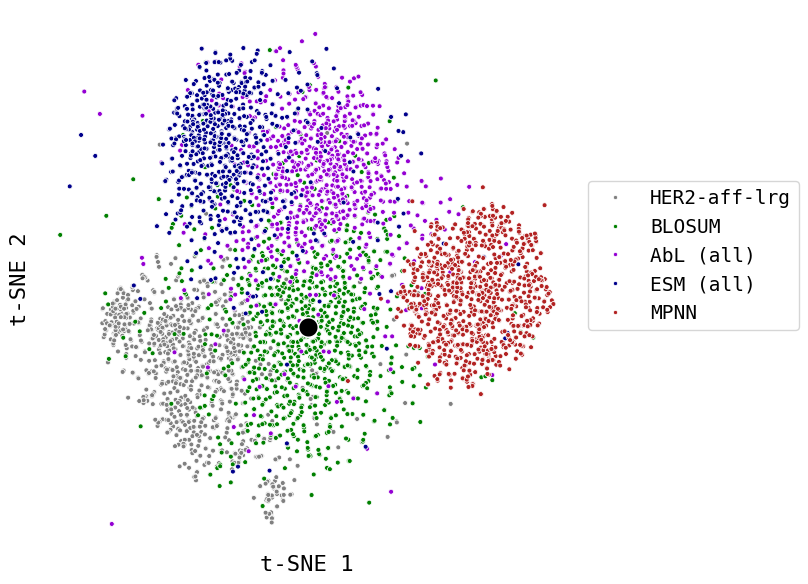

In [21]:
# plot
from src.plotting import plot_tsne, get_method_colour_map

# np.unique does not preserve order, so we need to sort it
methods_to_include = [y[i] for i in sorted(np.unique(y, return_index=True)[1])]
method_colour_map = get_method_colour_map()
dms_alt_palette = [method_colour_map[method] for method in methods_to_include if method != "trastuzumab"]

to_test = [0 for i in range(len(X))]  # all background in this example
plot_tsne(z, y, to_test=to_test, dms_alt_palette=dms_alt_palette, method_colour_map=method_colour_map,
          sizes={0: 50, 1: 50}, trastuzumab_size=200)